# 2D 实验的notebook

这个代码详细的完成一个Implicit的训练和推理

1. 加载数据集
2. 定义模型
3. 开始训练
4. 评估

## 加载数据集
- 数据集和验证集配置
- 分割数据集和验证集

In [73]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
ibc_parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(ibc_parent_dir)

from tqdm.auto import tqdm
from ibc import dataset, models, optimizers, trainer, utils
from scipy.spatial import ConvexHull
from ibc.trainer import PolicyType

许多超参需要调整，在这里调整吧

dataset的超参设置

In [74]:
experiment_name = "implicit_pipeline_10" # experiment name
custom_seed = 42

train_dataset_size = 10
train_batch_size = 8
trian_num_workers = 1

test_dataset_size = 500
test_batch_size = 8
test_num_workers = 1


训练的超参设置

In [75]:
coord_conv = True # 是否使用坐标卷积？
in_channels = 3 # 输入通道数，对应RGB
spatial_reduction = models.SpatialReduction.SPATIAL_SOFTMAX
policy_type = PolicyType
custom_dropout_prob = 0.1
custom_learning_rate = 0.001
custom_weight_decay = 0.0001

# train setting
checkpoint_every_n_steps = 100
eval_every_n_steps = 1000
log_every_n_steps = 10

implicit = True # 选择显式or隐式，这个代码现在只支持隐式
if implicit:
    policy_type = trainer.PolicyType.IMPLICIT
else:
    policy_type = trainer.PolicyType.EXPLICIT

In [76]:
train_dataset_config = dataset.DatasetConfig(
    dataset_size=train_dataset_size,
    seed=custom_seed, 
    # 其他参数默认
)
train_dataset = dataset.CoordinateRegression(train_dataset_config)  # data: coordinate regression shape:（N,2)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=trian_num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Test split.
test_dataset_config = dataset.DatasetConfig(
    dataset_size=test_dataset_size,
    seed=custom_seed, 
)
test_dataset = dataset.CoordinateRegression(test_dataset_config)
test_dataset.exclude(train_dataset.coordinates) # 防止测试集中包含训练集的数据
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=test_num_workers,
    pin_memory=torch.cuda.is_available(),
)

Resampled 1 data points.


In [77]:
print(train_dataloader.dataset.get_target_bounds())

[[-1. -1.]
 [ 1.  1.]]


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 3, 96, 96])
batch[1].shape:torch.Size([8, 2])
target is : tensor([ 0.8105, -0.3895])
unscaled target is:  [86. 29.]


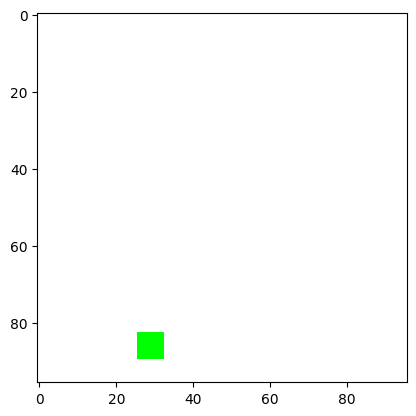

In [78]:
batch = next(iter(train_dataloader))    # 可以更改为test_dataloader查看测试集的shape

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

# Visualize one instance.
image, target = train_dataset[np.random.randint(len(train_dataset))]
print("target is :", target) # target is normalization in [-1, 1]

# 坐标缩放
target_unscaled = np.array(target)
target_unscaled += 1
target_unscaled /= 2
target_unscaled *= train_dataset.resolution[0] - 1

print("unscaled target is: ", target_unscaled)

plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()

## 构造网络模型

**配置网络参数**

网络与优化器配置：

In [79]:
if coord_conv: # 如果启用坐标卷积（coord_conv），输入通道数+2（添加x/y坐标通道）
    in_channels += 2
residual_blocks = [16, 32, 32]  # 3个残差块,通道: 16 32 32
cnn_config = models.CNNConfig(in_channels, residual_blocks) # CNN配置
print("in channels:", in_channels)

input_dim = 16  # 1x1 conv that reduces to 16 channels.
output_dim = 2
if spatial_reduction == models.SpatialReduction.SPATIAL_SOFTMAX:
    input_dim *= 2
if policy_type == trainer.PolicyType.IMPLICIT:
    input_dim += 2  # Dimension of the targets. o+a
    # print("input dimension:", input_dim)
    output_dim = 1

print("input dimension:", input_dim)

mlp_config = models.MLPConfig(
    input_dim=input_dim,
    hidden_dim=256,
    output_dim=output_dim,
    hidden_depth=1,
    dropout_prob=custom_dropout_prob,
)

model_config = models.ConvMLPConfig(
    cnn_config=cnn_config,
    mlp_config=mlp_config,
    spatial_reduction=spatial_reduction,
    coord_conv=coord_conv,
)

optim_config = optimizers.OptimizerConfig(
    learning_rate=custom_learning_rate,
    weight_decay=custom_weight_decay,
)

in channels: 5
input dimension: 34


打印配置：

In [80]:
print("mlp_config:", mlp_config)
print("model_config:", model_config)
print("optim_config:", optim_config)
net = models.ConvMLP(model_config)
print("The network structure is: \n", net)
print("The whole network has {} parameters".format(sum(p.numel() for p in net.parameters())))

mlp_config: MLPConfig(input_dim=34, hidden_dim=256, output_dim=1, hidden_depth=1, dropout_prob=0.1, activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>)
model_config: ConvMLPConfig(cnn_config=CNNConfig(in_channels=5, blocks=[16, 32, 32], activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>), mlp_config=MLPConfig(input_dim=34, hidden_dim=256, output_dim=1, hidden_depth=1, dropout_prob=0.1, activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>), spatial_reduction=<SpatialReduction.SPATIAL_SOFTMAX: <class 'ibc.modules.SpatialSoftArgmax'>>, coord_conv=True)
optim_config: OptimizerConfig(learning_rate=0.001, weight_decay=0.0001, beta1=0.9, beta2=0.999, lr_scheduler_step=100, lr_scheduler_gamma=0.99)
The network structure is: 
 ConvMLP(
  (cnn): CNN(
    (net): Sequential(
      (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_

创建训练进程：

虽然将训练细节在下面已经实现了，但是还需要`train_state`来保存checkpoint

In [ ]:
train_state: trainer.TrainStateProtocol
if policy_type == trainer.PolicyType.EXPLICIT:
    train_state = trainer.ExplicitTrainState.initialize(
        model_config=model_config,
        optim_config=optim_config,
        device_type="cuda",
    )
else:
    target_bounds = train_dataloader.dataset.get_target_bounds()
    stochastic_optim_config = optimizers.DerivativeFreeConfig(
        bounds=target_bounds,
        train_samples=128,
    )

    train_state = trainer.ImplicitTrainState.initialize(
        model_config=model_config,
        optim_config=optim_config,
        stochastic_optim_config=stochastic_optim_config,
        device_type="cuda",
    )

Using device: cuda


In [82]:
device_type = "cuda"

device = torch.device(device_type if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# define model
model = models.EBMConvMLP(config=model_config)
model.to(device)

# use adam optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=optim_config.learning_rate,
    weight_decay=optim_config.weight_decay,
    betas=(optim_config.beta1, optim_config.beta2),
)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=optim_config.lr_scheduler_step,
    gamma=optim_config.lr_scheduler_gamma,
)

stochastic_optimizer = optimizers.DerivativeFreeOptimizer.initialize(
    stochastic_optim_config,
    device_type,
)

Using device: cuda


## 开始训练

In [83]:
import torch.nn as nn
import torch.nn.functional as F

from ibc.experiment import Experiment, TensorboardLogData
experiment = Experiment(
    identifier = experiment_name, # custom experiment name
).assert_new()


In [84]:
steps = 0
for epoch in tqdm(range(2000)):
    if not steps % checkpoint_every_n_steps:
        experiment.save_checkpoint(train_state, step=steps)

    if not steps % eval_every_n_steps:
        test_log_data = train_state.evaluate(test_dataloader)
        experiment.log(test_log_data, step=steps)

    for batch in train_dataloader:
        
        model.train()
        input, target = batch 

        input_tensor = torch.tensor(input).to(device)
        target_tensor = torch.tensor(target).to(device)

        # Generate N negatives, one for each element in the batch: (B, N, D).
        negatives = stochastic_optimizer.sample(input_tensor.size(0), model)

        # Merge target and negatives: (B, N+1, D).
        targets = torch.cat([target_tensor.unsqueeze(dim=1), negatives], dim=1)

        # Generate a random permutation of the positives and negatives.
        permutation = torch.rand(targets.size(0), targets.size(1)).argsort(dim=1)
        targets = targets[torch.arange(targets.size(0)).unsqueeze(-1), permutation]

        # Get the original index of the positive. This will serve as the class label for the loss.
        ground_truth = (permutation == 0).nonzero()[:, 1].to(device)

        # For every element in the mini-batch, there is 1 positive for which the EBM
        # should output a low energy value, and N negatives for which the EBM should output high energy values.
        energy = model(input_tensor, targets)

        # Interpreting the energy as a negative logit, we can apply a cross entropy loss to train the EBM.
        logits = -1.0 * energy
        loss = F.cross_entropy(logits, ground_truth)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

        steps += 1  # ensure other moduels run
        
        train_log_data = TensorboardLogData(
            scalars={
                "train/loss": loss.item(),
                "train/learning_rate": scheduler.get_last_lr()[0],
            }
        )

        # Log to tensorboard.
        if not steps % log_every_n_steps:
            experiment.log(train_log_data, step=steps)

# Save one final checkpoint.
experiment.save_checkpoint(train_state, step=steps)

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_4010592/3031435480.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input).to(device)
/tmp/ipykernel_4010592/3031435480.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target).to(device)
100%|██████████| 2000/2000 [03:00<00:00, 11.06it/s]


## Evaluation

In [85]:
import dataclasses
import pathlib

from ibc.dataset import CoordinateRegression
from plot import plot

In [86]:
@dataclasses.dataclass
class Args:
    # experiment_name: experiment_name  # drop了，在后面的代码直接指定
    plot_dir: str = "assets"
    dpi: int = 200
    threshold: float = 140

dataset_test = test_dataloader.dataset
dataset_train = train_dataloader.dataset
assert isinstance(dataset_test, CoordinateRegression)
assert isinstance(dataset_train, CoordinateRegression)

推理代码实现

推理的一些参数如下：
- `noise_scale`: float = 0.33
- `noise_shrink`: float = 0.5
- `iters`: int = 3
- `train_samples`: int = 256
- `inference_samples`: int = 2 ** 14

In [87]:
noise_scale = stochastic_optim_config.noise_scale
# Make sure bounds tensor matches the dtype of the samples and model (float32)
bounds = torch.as_tensor(stochastic_optimizer.bounds, dtype=torch.float32, device=device)

size = (input.to(device).size(0) * stochastic_optimizer.inference_samples, stochastic_optimizer.bounds.shape[1])
print("size =", size)

samples = np.random.uniform(stochastic_optimizer.bounds[0, :], stochastic_optimizer.bounds[1, :], size=size)
# Use float32 numpy -> torch conversion to match model dtype (float32)
samples = torch.as_tensor(samples.astype(np.float32), dtype=torch.float32, device=device)
samples = samples.reshape(input.to(device).size(0), stochastic_optim_config.inference_samples, -1)

print("samples.shape: ", samples.shape)

size = (32768, 2)
samples.shape:  torch.Size([2, 16384, 2])


evaluate前的准备

In [88]:
noise_scale = stochastic_optim_config.noise_scale
# Make sure bounds tensor matches the dtype of the samples and model (float32)
bounds = torch.as_tensor(stochastic_optimizer.bounds, dtype=torch.float32, device=device)

total_mse = 0.0
num_small_err = 0
pixel_error = []

In [89]:
for batch in tqdm(test_dataloader):
    input, target = batch
    input_tensor = torch.tensor(input).to(device)

    size = (input.to(device).size(0) * stochastic_optimizer.inference_samples, stochastic_optimizer.bounds.shape[1])

    samples = np.random.uniform(stochastic_optimizer.bounds[0, :], stochastic_optimizer.bounds[1, :], size=size)
    # Use float32 numpy -> torch conversion to match model dtype (float32)
    samples = torch.as_tensor(samples.astype(np.float32), dtype=torch.float32, device=device)
    samples = samples.reshape(input.to(device).size(0), stochastic_optim_config.inference_samples, -1)

    model.eval()    # switch model to "evaluation mode"    
    # execute infer
    for i in range(stochastic_optim_config.iters):
        # Compute energies.
        energies = model(input_tensor, samples)
        probs = F.softmax(-1.0 * energies, dim=-1)  # softmax

        # Resample with replacement.
        idxs = torch.multinomial(probs, stochastic_optimizer.inference_samples, replacement=True)
        samples = samples[torch.arange(samples.size(0)).unsqueeze(-1), idxs]

        # Add noise and clip to target bounds.
        samples = samples + torch.randn_like(samples) * noise_scale
        samples = samples.clamp(min=bounds[0, :], max=bounds[1, :])

        noise_scale *= stochastic_optimizer.noise_shrink

    # Return target with highest probability.
    energies = model(input_tensor, samples)
    probs = F.softmax(-1.0 * energies, dim=-1)
    best_idxs = probs.argmax(dim=-1)
    prediction =  samples[torch.arange(samples.size(0)), best_idxs, :].cpu().numpy()

    target = target.cpu().numpy()

    # 坐标缩放
    pred_unscaled = np.array(prediction)
    pred_unscaled += 1
    pred_unscaled /= 2
    pred_unscaled[:, 0] *= dataset_test.resolution[0] - 1
    pred_unscaled[:, 1] *= dataset_test.resolution[1] - 1

    target_unscaled = np.array(target)
    target_unscaled += 1
    target_unscaled /= 2
    target_unscaled[:, 0] *= dataset_test.resolution[0] - 1
    target_unscaled[:, 1] *= dataset_test.resolution[1] - 1

    # error
    diff = pred_unscaled - target_unscaled
    error = np.asarray(np.linalg.norm(diff, axis=1))
    num_small_err += len(error[error < 1.0])
    pixel_error.extend(error.tolist())
    total_mse += (diff ** 2).mean(axis=1).sum()

  0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_4010592/2213760119.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input).to(device)
100%|██████████| 63/63 [00:01<00:00, 54.01it/s]


评估loss并绘制预测图像

In [90]:
total_test = len(dataset_test)
average_mse = total_mse / total_test
print(f"Test set MSE: {average_mse} ({num_small_err}/{total_test})")

test_coords = dataset_test.coordinates
train_coords = dataset_train.coordinates

# Plot and dump to disk.
plot_dir = pathlib.Path(Args.plot_dir)
plot_dir.mkdir(parents=True, exist_ok=True)

experiment = Experiment(
    identifier=experiment.identifier,
).assert_exists()

plot(
    train_coords,
    test_coords,
    np.asarray(pixel_error),
    test_dataloader.dataset.resolution,
    plot_dir / f"{experiment.identifier}.png",
    Args.dpi,
    Args.threshold,
)

current_dir = pathlib.Path.cwd()
print("Image be saved to:", current_dir / plot_dir / f"{experiment.identifier}.png")

Test set MSE: 0.08823486922681331 (496/500)
Image be saved to: /home/junbo/ibc-torch/mycode/assets/implicit_pipeline_10.png
